**Prediction**\
\
This is a prediction part. 
And because of section description has sentences and paragraphs we needed to use natural language processing (NLP) toolkit. For using it, some libbraries need to download after every runtime.

In [0]:
import nltk
nltk.download('popular')

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
pd.set_option('display.max_columns', None)

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk.stem import WordNetLemmatizer
import string

import base64
import string
import re
from collections import Counter
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from nltk.corpus import stopwords
import string 
import re
import spacy 
spacy.load('en_core_web_sm')
from spacy.lang.en import English
parser = English()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


The main libraries used are stopwords (from stopwords) and spacy are used for eliminating the common words.

In [0]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Clean_data1.csv')

In [5]:
df.shape

(11272, 14)

In [0]:
del df['Unnamed: 0']

In [7]:
df.shape

(11272, 13)

In [0]:
df1 = df.copy()

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

In [0]:
STOPLIST = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS))
SYMBOLS = " ".join(string.punctuation).split(" ")

In [0]:
def tokenizetext(sample):
    text = sample.strip().replace("\n", " ").replace("\r", " ")
    text = text.lower()
    tokens = parser(text)
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas
    tokens = [tok for tok in tokens if tok not in STOPLIST]
    tokens = [tok for tok in tokens if tok not in SYMBOLS]
    return tokens

This function is used for including each word from description into list form and also common english words, pronouns and sysmbols like dots and commas are also eliminated.

In [0]:
vectorizer = CountVectorizer(tokenizer = tokenizetext, ngram_range = (1,3), min_df = 0.06)

In [0]:
vectorizer_features = vectorizer.fit_transform(df1['description'])

This CountVectorizer function from sklean converts the words into the vectors or features. Like one hot encoding.

In [14]:
vectorizer_features.shape

(11272, 666)

In [15]:
vectorizer_features

<11272x666 sparse matrix of type '<class 'numpy.int64'>'
	with 991737 stored elements in Compressed Sparse Row format>

In [0]:
vectorized_df = pd.DataFrame(vectorizer_features.todense(), columns = vectorizer.get_feature_names())
df_vectorized = pd.concat([df1, vectorized_df], axis = 1)

In [0]:
df_vectorized.drop('description', axis = 1, inplace = True)
df_vectorized.dropna(inplace=True)

In [0]:
df_vectorized.head()

There are large no of coloumns. While converting to pdf its taking lot of pages.

In [0]:
columns_to_1_hot = ['employment_type', 'required_experience', 'required_education', 'industry', 'function']

for column in columns_to_1_hot:
    encoded = pd.get_dummies(df_vectorized[column])
    df_vectorized = pd.concat([df_vectorized, encoded], axis = 1)

Then other remaining features are converted to one hot encoding. 

In [0]:
columns_to_1_hot += ['title', 'city', 'country_name']
df_vectorized.drop(columns_to_1_hot, axis = 1, inplace = True)

Some features like title, city and country are eliminated because

---


title = this part is covered in description. 

---
city and country these are not much affecting in prediction.

---



In [0]:
target = df_vectorized['fraudulent']
features = df_vectorized.drop('fraudulent', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.1, stratify = target, random_state=42)

In [0]:
Model_Score = []
Model_Name = []

In [0]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

**Logistic Regresssion**

First it is performed **without tuning hyperparameters**

In [24]:
logmodel = LogisticRegression(max_iter = 20000)
logmodel.fit(X_train,y_train)
print('logreg')

#Predicting on the Test Set
predictions = logmodel.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

logreg
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1103
           1       0.89      0.64      0.74        25

    accuracy                           0.99      1128
   macro avg       0.94      0.82      0.87      1128
weighted avg       0.99      0.99      0.99      1128



Then by using GridSearchCV function a 3 fold cross validation is done and also **tuned the hyperparameters**.

In [0]:
log_reg = LogisticRegression()
c_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
penalty_options = ['l1', 'l2']

param_grid = dict(C = c_values, penalty = penalty_options)

In [0]:
grid_tfidf = GridSearchCV(log_reg, param_grid = param_grid, cv = 3, scoring = 'roc_auc', n_jobs = -1, verbose=1)

In [27]:
grid_tfidf.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   25.7s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=1)

In [0]:
log_reg_pred = grid_tfidf.predict(X_test)

In [49]:
print (roc_auc_score(y_test, log_reg_pred))
print (classification_report(y_test, log_reg_pred))

0.7795466908431551
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1103
           1       0.93      0.56      0.70        25

    accuracy                           0.99      1128
   macro avg       0.96      0.78      0.85      1128
weighted avg       0.99      0.99      0.99      1128



Even though data of fraudelent = 1 is less, it gives good precision and f1 score.

In [0]:
Model_Name.append('Logistic_Regression')
Model_Score.append(round(roc_auc_score(y_test, log_reg_pred), 4))

**KNN**

In [31]:
knn = KNeighborsClassifier()
k_range = list(np.arange(2, 10, 2))
param_grid_knn = dict(n_neighbors = k_range)
print (param_grid_knn)

{'n_neighbors': [2, 4, 6, 8]}


In [0]:
grid_knn = GridSearchCV(knn, param_grid_knn, cv = 3, scoring = 'roc_auc', n_jobs = -1, verbose = 1)

In [33]:
grid_knn.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  4.4min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': [2, 4, 6, 8]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring='roc_auc',
             verbose=1)

In [34]:
grid_knn.best_score_

0.9331061452522008

In [35]:
grid_knn.best_params_

{'n_neighbors': 8}

In [0]:
knn_pred = grid_knn.predict(X_test)

In [37]:
print (roc_auc_score(y_test, knn_pred))
print (classification_report(y_test, knn_pred))

0.72
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1103
           1       1.00      0.44      0.61        25

    accuracy                           0.99      1128
   macro avg       0.99      0.72      0.80      1128
weighted avg       0.99      0.99      0.99      1128



In [0]:
Model_Name.append('KNN')
Model_Score.append(round(roc_auc_score(y_test, knn_pred), 4))

**SVC**

In [39]:
svc = SVC()
kernel = ['linear', 'rbf']
param_grid_knn = dict(kernel = kernel)
print (param_grid_knn)

{'kernel': ['linear', 'rbf']}


In [0]:
grid_svc = GridSearchCV(svc, param_grid_knn, cv = 3, scoring = 'roc_auc', n_jobs = -1, verbose = 2)

In [41]:
grid_svc.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   31.9s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'kernel': ['linear', 'rbf']}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring='roc_auc',
             verbose=2)

In [42]:
grid_svc.best_score_

0.9739281333637583

In [43]:
grid_svc.best_params_

{'kernel': 'linear'}

In [0]:
svc_pred = grid_svc.predict(X_test)

In [45]:
print (roc_auc_score(y_test, svc_pred))
print (classification_report(y_test, svc_pred))

0.8195466908431551
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1103
           1       0.94      0.64      0.76        25

    accuracy                           0.99      1128
   macro avg       0.97      0.82      0.88      1128
weighted avg       0.99      0.99      0.99      1128



In [0]:
Model_Name.append('SVC')
Model_Score.append(round(roc_auc_score(y_test, svc_pred), 4))

**MLP Classifier**

In [0]:
mlp = MLPClassifier(solver = 'sgd', activation = 'relu', hidden_layer_sizes = (100, 50, 30), max_iter = 1000)

In [48]:
mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 50, 30), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [51]:
mlp_pred = mlp.predict(X_test)
print (roc_auc_score(y_test, mlp_pred))
print (classification_report(y_test, mlp_pred))

0.78
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1103
           1       1.00      0.56      0.72        25

    accuracy                           0.99      1128
   macro avg       1.00      0.78      0.86      1128
weighted avg       0.99      0.99      0.99      1128



In [0]:
Model_Name.append('MLP-NN (sgd)')
Model_Score.append(round(roc_auc_score(y_test, mlp_pred), 4))

**Model Comparison**

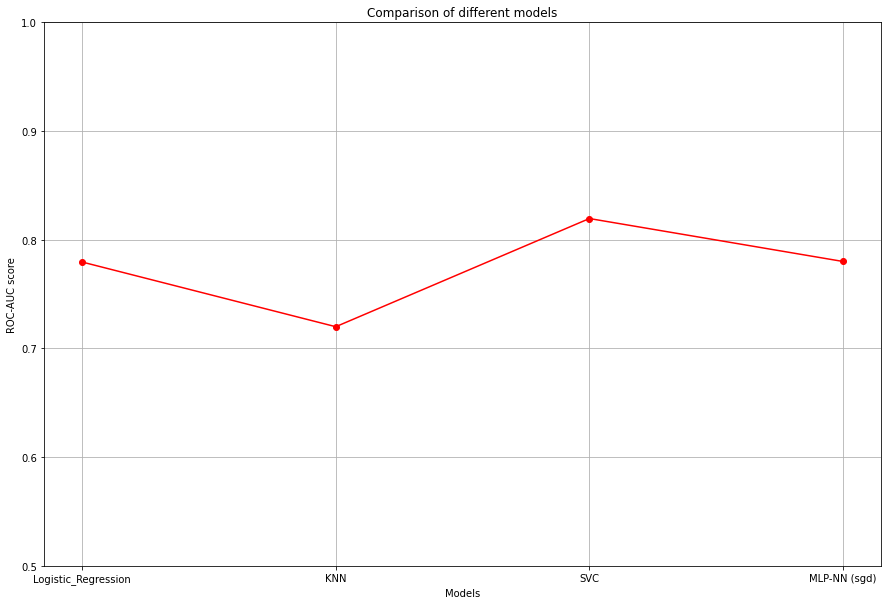

In [59]:
plt.figure(figsize = (15, 10))
plt.plot(Model_Name,Model_Score, marker = 'o', color = 'red')
plt.title('Comparison of different models')
plt.xlabel('Models')
plt.ylabel('ROC-AUC score')
plt.ylim(0.5, 1.0)
plt.grid()
plt.savefig('Model_compare.jpeg')
plt.show()